# Direct S3 Access tutorial

Modified based on PO.DAAC tutorial S3-Access.ipynb https://github.com/podaac/tutorials/blob/0b70d4038a542c8911daf80e82ddfac0cf54b75f/notebooks/s3/S3-Access.ipynb

Focus on openning multiple granules using xarray.open_mfdataset.

In [1]:
import xarray as xr
import requests,os
import s3fs
import pylab as plt

## Authenticate with EDL and retrieve temporary S3 credentials:

You need a temporary S3 credential to access data in the cloud from within the AWS us-west-2 region. To do this, we use our earthdata login when calling a special API endpoint to receive this temporary token.

In [2]:
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
    'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'}

def get_temp_creds():
    temp_creds_url = s3_cred_endpoint['podaac']
    return requests.get(temp_creds_url).json()

creds = get_temp_creds()


In [3]:
s3 = s3fs.S3FileSystem(anon=False,key=creds['accessKeyId'], secret=creds['secretAccessKey'], token=creds['sessionToken'])

#############        examples

all_collection=sorted(s3.glob('s3://podaac-ops-cumulus-protected/*')) #list all po.daac collections, 
print('There are %i collections in POCLOUD. Examples: \n'%len(all_collection))

print(all_collection[:10],"\n") #delete [:3] to show short_names of all collections

mursst=s3.glob('s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/*nc') 
print('There are %i granules in MUR-JPL-L4.'%len(mursst))

swotL2ssh=s3.glob('s3://podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_SCIENCE_V1/*nc') 
print('There are %i granules in SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_SCIENCE_V1.'%len(swotL2ssh))

preswot_llc4320=s3.glob('s3://podaac-ops-cumulus-protected/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0/*nc')
print('There are %i granules in MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0.'%len(preswot_llc4320))

preswot_llc4320[:3]

There are 352 collections in POCLOUD. Examples: 

['podaac-ops-cumulus-protected/ABI_G16-STAR-L2P-v2.70', 'podaac-ops-cumulus-protected/ABI_G16-STAR-L3C-v2.70', 'podaac-ops-cumulus-protected/ABI_G17-STAR-L2P-v2.71', 'podaac-ops-cumulus-protected/ABI_G17-STAR-L3C-v2.71', 'podaac-ops-cumulus-protected/AHI_H08-STAR-L2P-v2.70', 'podaac-ops-cumulus-protected/AHI_H08-STAR-L3C-v2.70', 'podaac-ops-cumulus-protected/ALT_TIDE_GAUGE_L4_OST_SLA_US_WEST_COAST_DAILY', 'podaac-ops-cumulus-protected/AMSR2-REMSS-L2P-v8a', 'podaac-ops-cumulus-protected/AMSR2-REMSS-L2P_RT_v8a', 'podaac-ops-cumulus-protected/AMSR2-REMSS-L3U-v8a'] 

There are 7108 granules in MUR-JPL-L4.
There are 10218 granules in SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_SCIENCE_V1.
There are 429 granules in MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0.


['podaac-ops-cumulus-protected/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0/LLC4320_pre-SWOT_ACC_SMST_20110913.nc',
 'podaac-ops-cumulus-protected/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0/LLC4320_pre-SWOT_ACC_SMST_20110914.nc',
 'podaac-ops-cumulus-protected/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0/LLC4320_pre-SWOT_ACC_SMST_20110915.nc']

In [4]:
#open a single SST file (the first one at 2002-06-01T09:00:00)

data=xr.open_dataset(s3.open(mursst[0]))
#data=xr.open_dataset(s3.open(preswot_llc4320[0]))

data

<xarray.Dataset>
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2002-06-01T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [5]:
#open multiple files all at once (the first ten in this example mursst[:10])

#fileset = [s3.open(file) for file in preswot_llc4320[:10]]
fileset = [s3.open(file) for file in mursst[:10]]
data = xr.open_mfdataset(fileset)   #, combine='by_coords', engine='h5netcdf' )

data

#Does anybody want to experiment Dask? 

<xarray.Dataset>
Dimensions:           (time: 10, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-06-1...
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [33]:
#get a subset (California Current, upwelling region)
#data is sliced but not loaded into memory yet

#dsubset=data.Salt.sel(i=slice(1, 40), j=slice(1,10), k=slice(1,10) )
dsubset=data.analysed_sst.sel(lat=slice(30, 40), lon=slice(-130, -110) )

dsubset

<xarray.DataArray 'analysed_sst' (time: 10, lat: 1001, lon: 2001)>
dask.array<getitem, shape=(10, 1001, 2001), dtype=float32, chunksize=(1, 1001, 2001), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-06-10T09:00:00
  * lat      (lat) float32 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float32 -130.0 -130.0 -130.0 -130.0 ... -110.0 -110.0 -110.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      [-32767]
    valid_max:      [32767]
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

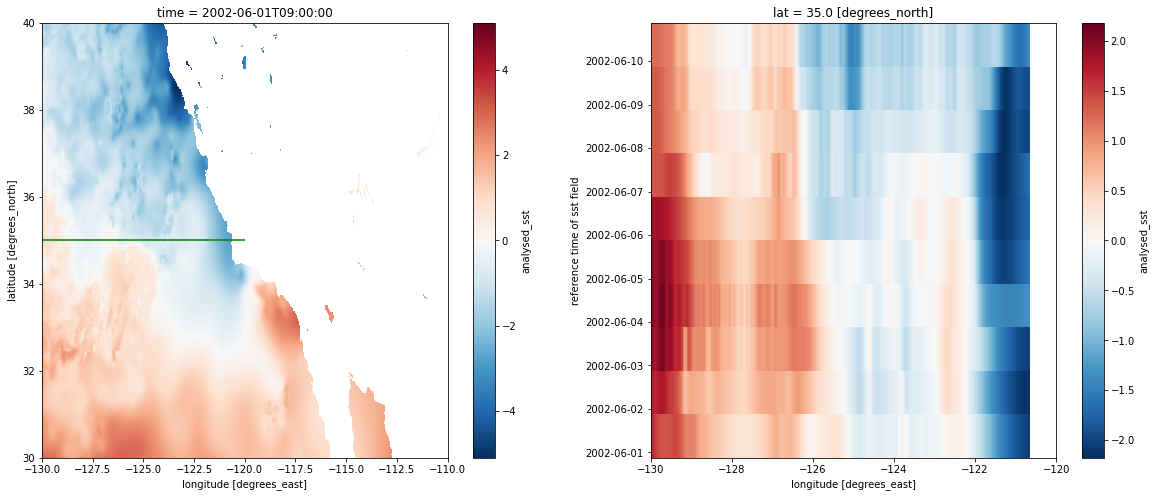

In [34]:
#plot an example of the sliced array
fig,ax=plt.subplots(1,2,figsize=(20,8))
dd=dsubset[0,...] #get the first time setp
(dd-dd.mean()).plot(ax=ax[0])
#dd.plot(ax=ax[0])

ax[0].hlines(35,-130,-120,color='g')

dd=dsubset.sel(lat=35,lon=slice(-130,-120))
(dd-dd.mean()).plot(ax=ax[1])